# Build a Prior Knowledge Network

This vignette displays some examples of what can be achieved using **NORDic** to build a prior knowledge network from **combining** other sources than/in the [STRING database](https://string-db.org/). We illustrate this by considering again the Congenital Central Hypoventilation Syndrome (CCHS).

In [1]:
from subprocess import call as sbcall
file_folder="ToyOndine/"
sbcall("mkdir -p "+file_folder, shell=True)

0

## Installation

In [2]:
import NORDic
! pip freeze | grep "NORDic"

NORDic==2.4.1


In [3]:
import os
import pandas as pd
from IPython.display import Image

## A. Prior Knowledge Network from *protein actions* and *protein-protein interactions* in the STRING database

By default, **NORDic NI** retrieves a prior knowledge network (a preselected subset of gene-to-gene regulatory interactions) using the STRING database. However, it might be unsatisfactory because these interactions rely on protein-protein interactions (PPIs) (so, not necessarily transcriptomic interactions, and missing out on other types of interactions). Moreover, the STRING database only provides *undirected*, *unsigned* interactions, which might become tricky to manage in terms of computational cost.

This subsection shows how to combine the outputs from *protein actions* and *interactions* in STRING to solve inconsistencies and get a larger, richer prior knowledge network than the default one built by **NORDic NI**. This network can then be fed to **NORDic** as a prior knowledge network, by instanciating parameter *network_fname* in the *network_identification* routine.

In [4]:
from NORDic.UTILS.STRING_utils import get_interactions_from_STRING, get_network_from_STRING
from NORDic.UTILS.utils_network import merge_network_PPI

### A.1 Retrieve the protein actions and predicted PPIs from the STRING database

Let us consider the top-6 genes which are returned when submitting a query to the [DisGeNet database](https://www.disgenet.org/browser/0/1/0/C1275808/) about genes associated with CCHS (score gda > 0.5), and return the PPI network from the STRING database

In [5]:
core_genes = ["PHOX2B", "RET", "BDNF", "ASCL1", "EDN3", "GDNF"]
taxon_id = 9606

if (not os.path.exists(file_folder+"network.csv")):
    ## one can select network_type="functional" or network_type="physical" to only consider PPIs
    network = get_network_from_STRING(core_genes, taxon_id, min_score=0., network_type="functional", 
            add_nodes=0, app_name="NORDic PKN", version="11.5", quiet=0)
    network.to_csv(file_folder+"network.csv")
network = pd.read_csv(file_folder+"network.csv", index_col=0)
network.sort_values(by="score", ascending=False)

<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING network interactions
<STRING> Getting the STRING network interactions


,preferredName_A,preferredName_B,sign,directed,score
26,RET,GDNF,2,0,0.999
28,GDNF,BDNF,2,0,0.950
8,PHOX2B,ASCL1,2,0,0.676
22,EDN3,GDNF,2,0,0.634
20,EDN3,RET,2,0,0.622
6,PHOX2B,EDN3,2,0,0.607
4,PHOX2B,RET,2,0,0.605
2,PHOX2B,GDNF,2,0,0.572
16,ASCL1,BDNF,2,0,0.519
14,ASCL1,GDNF,2,0,0.470


As previously mentioned, we also retrieve interactions from the protein actions data in the STRING database

In [6]:
if (not os.path.exists(file_folder+"PPI.csv")):
    # parameter strict=False allows to retrieve all interactions which involve at least ONE gene from core_genes
    # if that parameter is set to True, then only interactions involving TWO genes from core_genes are returned
    PPI = get_interactions_from_STRING(core_genes, taxon_id, min_score=0., strict=False, 
            version="11.0", app_name="NORDic PKN PPI", file_folder=file_folder)
    PPI.to_csv(file_folder+"PPI.csv")
PPI = pd.read_csv(file_folder+"PPI.csv", index_col=0)
PPI.sort_values(by="score", ascending=False)

<STRING> Retrieving the file from STRING... Saved at ToyOndine/protein_action_v11.0.tsv
<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING name mapping for genes
... Protein identifier matching
... Signed
... Directed
... Aggregate info
... Solve conflicts on direction
... Solve conflicts on sign for directed edges
... Aggregate info again
... Remove multiple undirected edges
... Solve conflicts on sign for undirected edges
... Aggregate info once again


,preferredName_A,preferredName_B,sign,directed,score
187,PLCG1,RET,1,0,0.965
545,DOK1,RET,1,0,0.955
659,EDN3,AVPR1A,2,0,0.951
508,EDN3,AVPR1A,2,0,0.951
70,EDN3,AGTR1,2,0,0.942
...,...,...,...,...,...
727,RET,CBLC,2,0,0.155
205,RET,CBLC,2,0,0.155
267,LRRK2,RET,2,0,0.154
824,LRRK1,RET,2,0,0.154


### A.2 Merge the two networks by solving inconsistencies on direction and sign

In [7]:
if (not os.path.exists(file_folder+"final_network.csv")):
    final_network = merge_network_PPI(network, PPI)
    final_network.to_csv(file_folder+"final_network.csv")
final_network = pd.read_csv(file_folder+"final_network.csv", index_col=0)
final_network.sort_values(by="score", ascending=False)

,preferredName_A,preferredName_B,sign,directed,score
104,RET,GDNF,2,0,0.999
661,RET,GDNF,2,0,0.999
187,PLCG1,RET,1,0,0.965
545,DOK1,RET,1,0,0.955
508,EDN3,AVPR1A,2,0,0.951
...,...,...,...,...,...
294,CBLB,RET,2,0,0.155
824,LRRK1,RET,2,0,0.154
267,LRRK2,RET,2,0,0.154
98,GDNF,GFRAL,2,0,0.152


### A.3 Merge the two networks by solving inconsistencies on direction and sign

If, computationally-speaking, the current number of edges present in *final_network* is too large, **NORDic** provides a function which returns the maximum edge score such that the core set of genes in *core_genes* is minimally (in terms of number of edges) connected. This function allows to select edges in a data-driven way, by considering all edges which scores are above the threshold returned by the function, and removing isolated genes (which total degree is equal to 0).

In [8]:
from NORDic.UTILS.utils_network import determine_edge_threshold, remove_isolated

In [9]:
threshold = determine_edge_threshold(final_network, core_genes)
threshold

0.342

In [10]:
final_network = remove_isolated(final_network.loc[final_network["score"]>=threshold])
final_network.sort_values(by="score", ascending=False)

472 genes in total in the network (294 genes in the largest connected component)
424 edges in trimmed network (down from 688 edges)


,preferredName_A,preferredName_B,sign,directed,score
661,RET,GDNF,2,0,0.999
104,RET,GDNF,2,0,0.999
187,PLCG1,RET,1,0,0.965
545,DOK1,RET,1,0,0.955
508,EDN3,AVPR1A,2,0,0.951
...,...,...,...,...,...
10,ASCL1,RET,2,0,0.397
131,ASCL1,UBQLN1,2,0,0.379
794,ASCL1,ID2,2,0,0.371
583,ASCL1,ID1,2,0,0.371


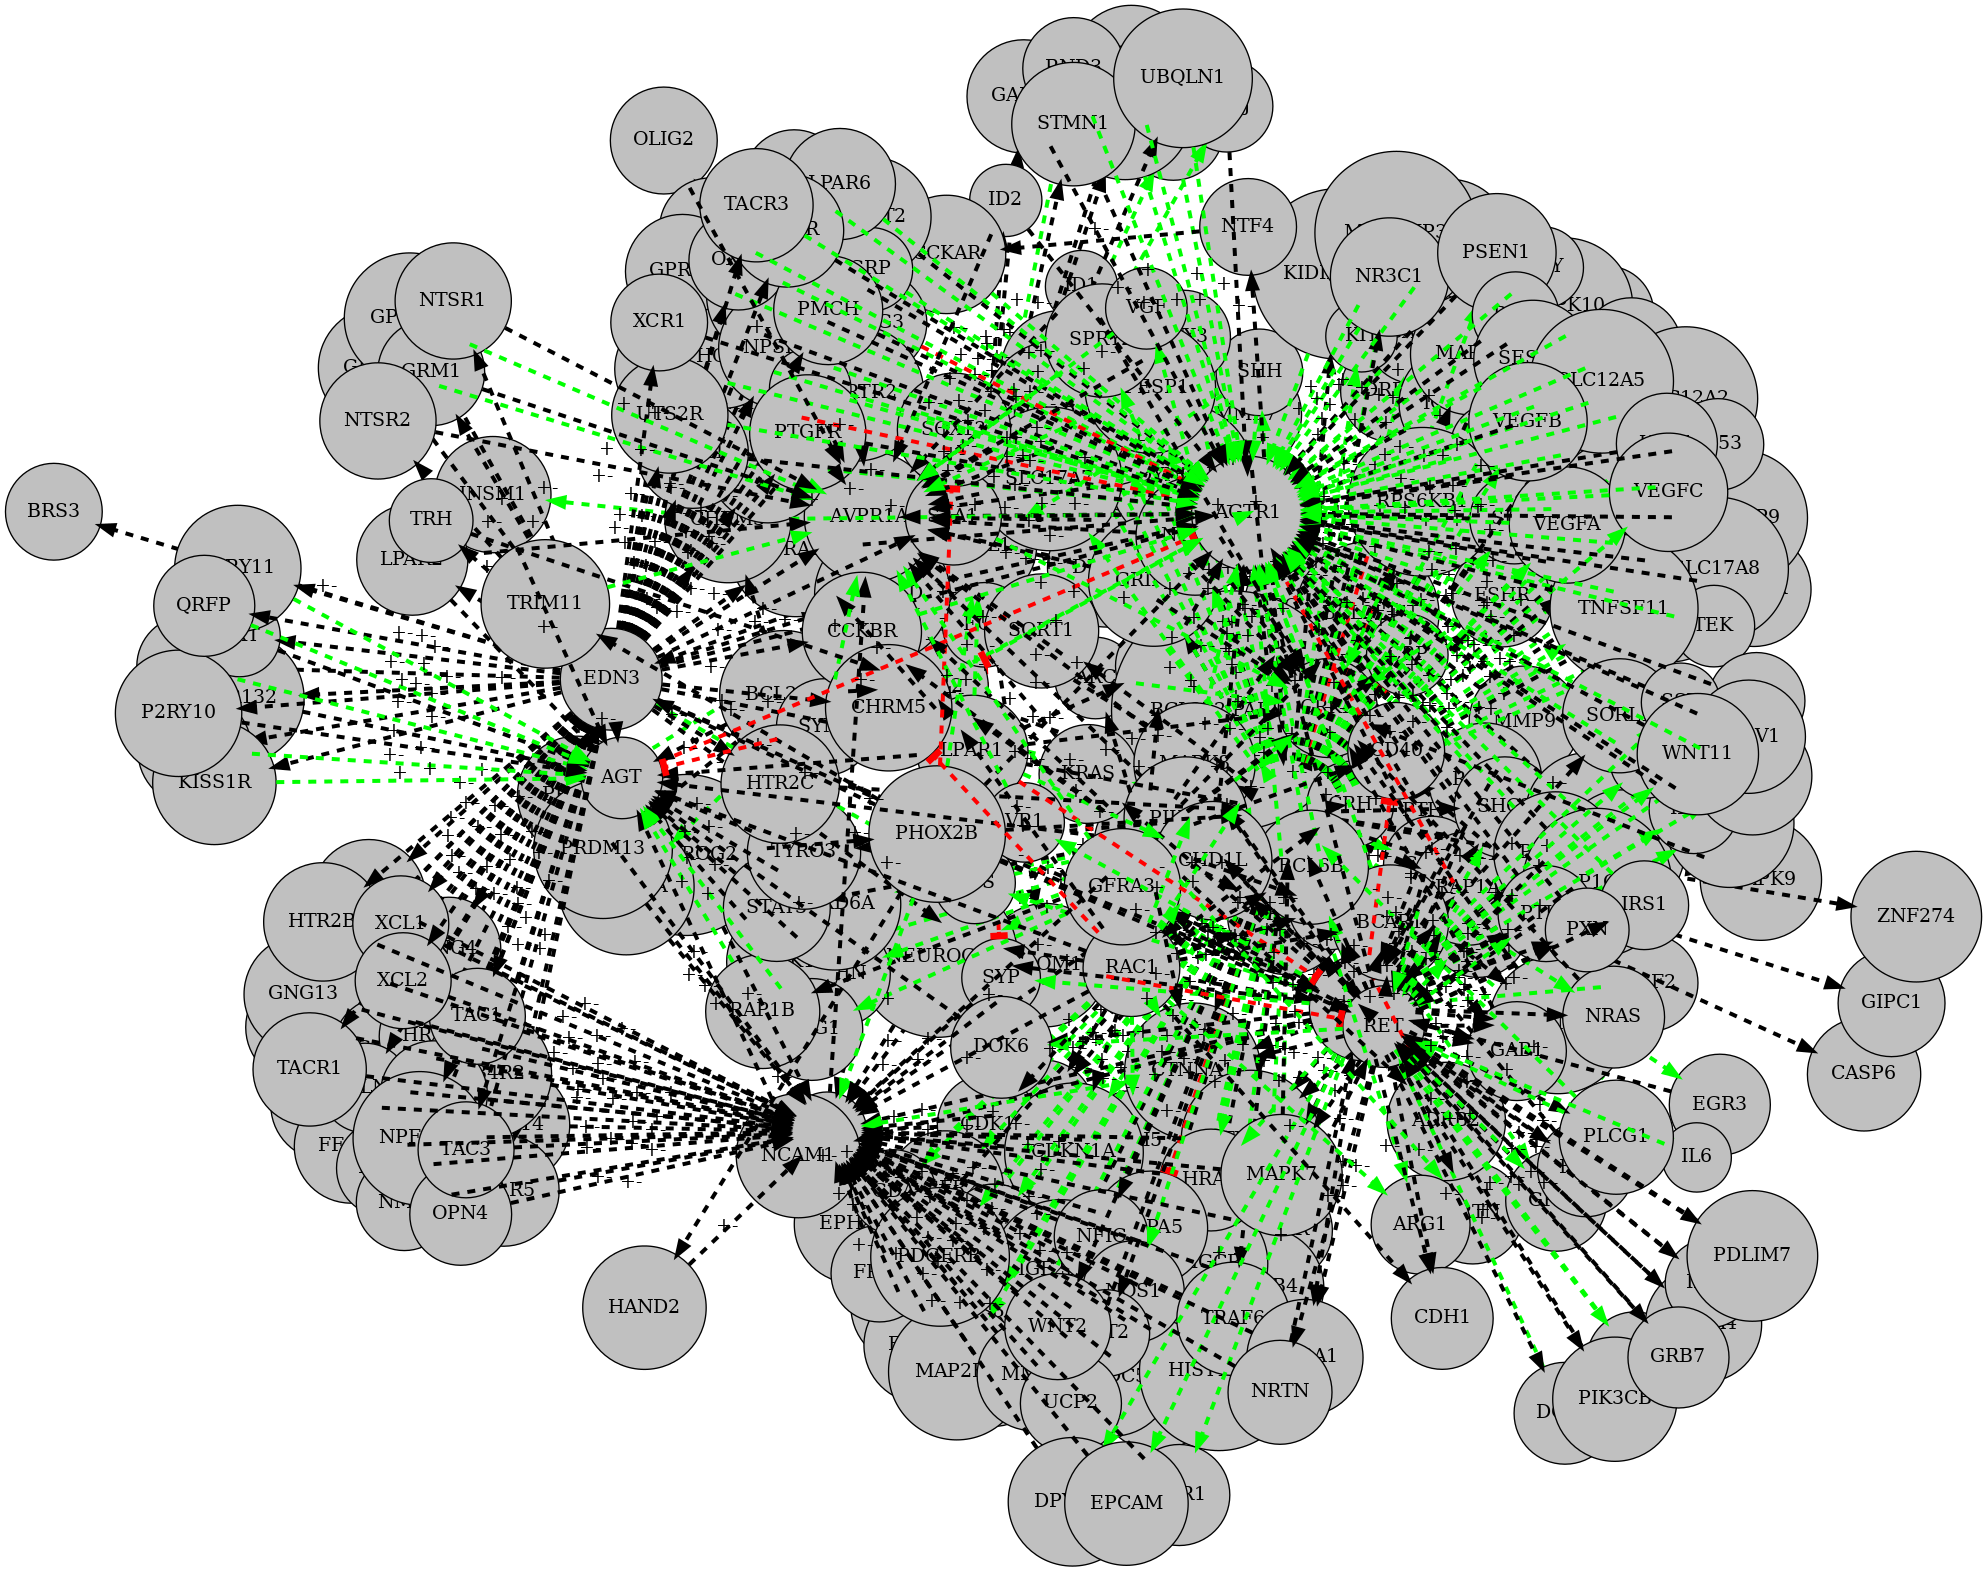

In [11]:
final_network.index = range(final_network.shape[0])
NETWORK_fname = file_folder+"network.tsv"
final_network.to_csv(NETWORK_fname, sep="\t", index=None)

from NORDic.UTILS.utils_plot import plot_influence_graph

plot_influence_graph(final_network, "preferredName_A", "preferredName_B", "sign", direction_col="directed", fname=file_folder+"graph_final", optional=True)
Image(filename=file_folder+'graph_final.png') 

Then, this approach of iteratively increasing the minimum score for edges in the network, and removing isolated nodes, can be iterated to get a smaller network which will be more tractable for downstream analysis. The whole pipeline in this section can be accessed through a single function *aggregate_networks*

In [12]:
from NORDic.UTILS.utils_network import aggregate_networks

help(aggregate_networks)

Help on function aggregate_networks in module NORDic.UTILS.utils_network:

aggregate_networks(file_folder, gene_list, taxon_id, min_score, network_type, app_name, version_net='11.5', version_act='11.0', quiet=0)
    This function performs the following pipeline to build a prior knowledge network based on a subset of genes
    - Retrieve protein actions and predicted PPIs from STRING
    - Merge the two networks while solving all inconsistencies (duplicates, paradoxes, etc.) in signs, directions, scores
    - Determine the greatest threshold on the edge score which allows all of the core gene set to be connected (binary search)
    - Trim out edges which scores are below the threshold, and remove all isolated nodes
    @param  file_folder     Python character string: relative path where to store files
    @param  gene_list       Python character string list: list of core gene symbols to preserve in the network
    @param  taxon_id        Python integer: NCBI taxonomy ID
    @param  min_

In [13]:
final_network2 = aggregate_networks(file_folder, core_genes, taxon_id, 0, "functional", 
                                    "NORDic whole PKN", quiet=1)
final_network2.sort_values(by="score", ascending=False)

<STRING> Retrieving the file from STRING... Saved at ToyOndine/protein_action_v11.0.tsv
<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING name mapping for genes
... Protein identifier matching
... Signed
... Directed
... Aggregate info
... Solve conflicts on direction
... Solve conflicts on sign for directed edges
... Aggregate info again
... Remove multiple undirected edges
... Solve conflicts on sign for undirected edges
... Aggregate info once again
580 genes in total in the network (360 genes in the largest connected component)
468 edges in trimmed network (down from 709 edges)


,preferredName_A,preferredName_B,sign,directed,score
104,RET,GDNF,2,0,0.999
187,PLCG1,RET,1,0,0.965
545,DOK1,RET,1,0,0.955
508,EDN3,AVPR1A,2,0,0.951
271,GDNF,BDNF,1,1,0.950
...,...,...,...,...,...
666,EDN3,FPR1,2,0,0.156
402,SHC2,RET,1,0,0.156
44,EDN3,FPR3,2,0,0.156
205,RET,CBLC,2,0,0.155


One might also be interested in focusing on the largest connected component of the network, and ignore the remainder

In [14]:
from NORDic.UTILS.utils_grn import reconnect_network

help(reconnect_network)

Help on function reconnect_network in module NORDic.UTILS.utils_grn:

reconnect_network(network_fname)
    Write the network with all isolated nodes (no ingoing/outgoing edges) filtered out
    @param  network_fname   Python character string: path to the .BNET associated with the network
    @return fname   Python character string: path to the .BNET associated with the reconnected network



## B. Prior Knowledge Network from the OmniPath database

One can be interested in pathways instead of gene/protein pairwise interactions. **NORDic** allows retrieving information from the [OmniPath database](https://omnipathdb.org/), which is nothing but a wrapper around the [Python API for OmniPath](https://pypi.org/project/omnipath/). It returns a network of gene interactions extracted from OmniPath (more specifically, from the database *sources_int*, if provided), along with gene annotations retrieved from the database mentioned in *domains_annot*

In [15]:
from NORDic.UTILS.utils_network import get_network_from_OmniPath

interactions, annot_wide = get_network_from_OmniPath(gene_list=core_genes, species="human",
                    min_curation_effort=-1, quiet=False)

Getting all interactions from OmniPath with the following parameters:{'organisms': 'human', 'include': None, 'sources': None, 'fields': ['curation_effort'], 'genesymbols': True, 'types': None, 'directed': False, 'signed': False}...
Define a network-formatted dataframe from these interactions...
Obtain the gene list or filter interactions using the given gene list (6 genes)...
1/1 gene annotation chunks


In [16]:
interactions

,preferredName_A,preferredName_B,directed,sign
4481,RET,GDNF,0,2
4482,GDNF,RET,1,1


In [17]:
annot_wide

label,favourable,level,n_high,n_low,n_medium,n_not_detected,organ,pathology,prognostic,score,status,tissue
genesymbol,,,,,,,,,,,,
ASCL1,False,Not detected,0,0,0,12,skin 1,False,False,0.01314,Enhanced,fibroblasts
BDNF,False,Not detected,0,2,0,9,skin 1,False,False,0.002844,Enhanced,fibroblasts
EDN3,True,NaN,NaN,NaN,NaN,NaN,colorectal cancer,True,False,0.07487,NaN,colorectal cancer
GDNF,False,Low,0,0,0,12,parathyroid gland,False,False,0.0001162,Supported,glandular cells
PHOX2B,False,Not detected,0,0,0,11,skin 1,False,False,0.1012,Enhanced,fibroblasts
RET,False,Not detected,0,3,2,7,liver,False,False,0.07941,Approved,cholangiocytes


The network in *interactions* can be fed to previously mentioned functions (*determine_edge_threshold*, *merge_network_PPI*, *reconnect_network*) to combine with other sources of regulatory interactions.